In [1]:
# pip install tensorflow

In [2]:
# pip install tensorflow_hub

In [3]:
# import moudle

import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub


In [4]:
# @title Define image loading and visualization functions  { display-mode: "form" }

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""

  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)

  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


In [5]:
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


2022-03-21 05:49:36.614218: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


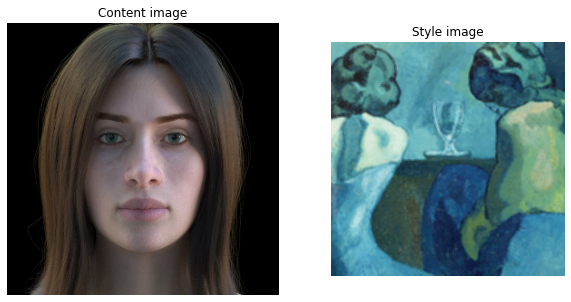

In [6]:
# @title Load example images  { display-mode: "form" }

content_image_url = 'https://static.turbosquid.com/Preview/2019/04/11__11_16_29/female_001_head_color_A.pngA0FCF6E5-7A61-43FA-A2BC-6739BE4C9FA7Large.jpg'  
style_image_url = 'https://artforum.com/uploads/upload.002/id12476/article00_1064x.jpg' 
output_image_size = 300  

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
style_img_size = (256, 256)  

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])



In [7]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)


In [8]:
# Stylize content image with given style image.

outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

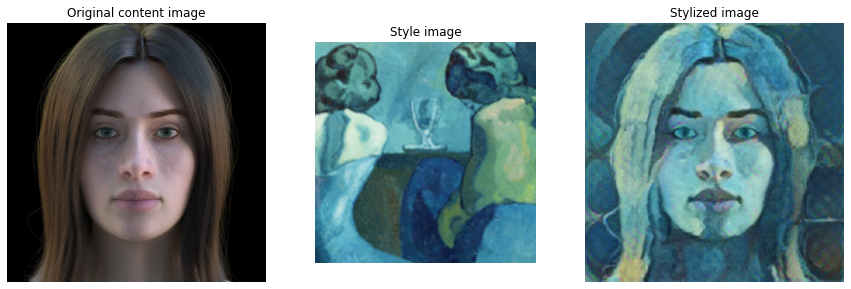

In [9]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])